# Modeling

Now that we have done feature engineering, we are ready to begin modeling.

During the modeling process, we will be focusing on the recall score as our main metric, and we will look to balance it with a relatively well performing `ROC_AUC` score. 

Our focus is on the recall score as maximizing this score is equivalent to reducing the **false negative rate**. i.e. the number of `wnvpresent` cases wrongly classified as negative when in fact they were positive.

This is because it is more important to ensure that no there are fewer false negatives than false positives as the former would be more dangerous, giving a false sense of security to the public if the predictions were released to the public.

## Table of contents
1. [All Imports](#All-Imports)
    - [Reading in datasets](#Reading-in-datasets)
    - [Setting X and y](#Setting-X-and-y)</p>
2. [Baseline Models](#Baseline-Models)
    - [Modeling on dataset with Features with multicollinearity](#Modeling-on-dataset-with-Features-with-multicollinearity)
    - [Dataset with Features with minimal multicollinearity](#Dataset-with-Features-with-minimal-multicollinearity)</p>
3. [Model Tuning](#Model-Tuning)
    - [Tuning with minimal multicollinearity](#Tuning-with-minimal-multicollinearity)
    - [Tuning with multicollinearity](#Tuning-with-multicollinearity)</p>
4. [Further tuning our best model](#Further-tuning-our-best-model)
    - [Final Model Tune](#Final-Model-Tune)</p>
5. [Kaggle Submission Prediction](#Kaggle-Submission-Prediction)

## All Imports

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (confusion_matrix, roc_auc_score, 
                             classification_report, accuracy_score, 
                             precision_score, f1_score, recall_score, 
                             roc_curve, auc, RocCurveDisplay, 
                            precision_recall_curve, average_precision_score)

from sklearn.ensemble import (RandomForestClassifier, 
ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier)

from xgboost import XGBClassifier

from sklearn.svm import SVC
import re
import seaborn as sns
from imblearn.over_sampling import SMOTE 

import pickle

plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)

---

### Reading in datasets

In [12]:
df_regression = pd.read_csv('../data/merged_train_final.csv')
df_multi = pd.read_csv('../data/merged_train_multi.csv')

test_df_regression = pd.read_csv('../data/merged_test_final.csv')
test_df_multi = pd.read_csv('../data/merged_test_multi.csv')

---

### Setting X and y

First we will set our `x` and `y` as per the features we identified in the feature engineering notebook.

In [158]:
# defining x and y for our dataset with multi-collinearity
x = df_multi.drop(['wnvpresent'],axis=1)
y = df_multi['wnvpresent']

y.value_counts(normalize=True)

0    0.948107
1    0.051893
Name: wnvpresent, dtype: float64

As we can see from the above output, our target `y` is very imbalanced. It is not advisable to conduct modeling on such a dataset, as such we will be using a technique known as **Synthetic Minority Oversampling Technique** (SMOTE for short) to help us rebalance the two classes before we do any modeling.

In [159]:
# train_test_split on our previously defined x and y
x_train, x_test, y_train, y_test= train_test_split(x,y,random_state=42)

# scaling our features before using SMOTE
ss = StandardScaler()
x_train_sc = ss.fit_transform(x_train)
x_test_sc = ss.transform(x_test)

In [160]:
# initialize SMOTE
sm = SMOTE(random_state=42)

# resample on our train data
x_train_sc, y_train = sm.fit_resample(x_train_sc,y_train)

# sanity check to ensure our classes are balanced now
y_train.value_counts(normalize=True)

0    0.5
1    0.5
Name: wnvpresent, dtype: float64

Now with this we can begin the modeling process. Any time we redefine `x` and `y`, we will need to carry out `SMOTE` as well.

---

## Baseline Models

In [58]:
# Instantiate models
models = {'lr': LogisticRegression(max_iter=5_000, random_state=42, solver='saga'),
          'rf': RandomForestClassifier(random_state=42),
          'gb': GradientBoostingClassifier(random_state=42),
          'et': ExtraTreesClassifier(random_state=42),
          'ada': AdaBoostClassifier(random_state=42),
          'svm': SVC(random_state=42, probability=True),
          'xgb': XGBClassifier(random_state=42)
}

In [59]:
# Function to run model -- input model
def get_model_scores(model_name,
                     mod, 
                     mod_params={}, 
                     grid_search=False):
    
    """Function accepts following inputs:
    Name of model (str), model to be used (str), 
    model params(dict, optional), grid_seach(boolean, optional)
    If grid_search is True, then please also input the relevant 
    params for GridSearching
    """
    
    # empty dict for appending results
    results = {}
    
    # instantiate pipe
    pipe = Pipeline([
            (mod, models[mod])
            ])
    
    # check if GridSearch true or false
    if grid_search:
        
        # combine vectorizer and mod params together
        gs_params = {}
        gs_params.update(mod_params)
        
        # instantiate GridSearchCV
        gs = GridSearchCV(pipe, 
                          param_grid=gs_params,
                          cv=5, 
                          verbose=2, 
                          n_jobs=-1)
        
        # fit model
        gs.fit(x_train_sc, y_train)
        pipe = gs
        
    else:
        # else fit model
        pipe.fit(x_train_sc, y_train)
    
    # create predictions and confusion matrix
    predictions = pipe.predict(x_test_sc)
    tn, fp, fn, tp = confusion_matrix(y_test, 
                                      predictions).ravel()
    y_test_pred_prob = pipe.predict_proba(x_test_sc)[:,1]
    y_train_pred_prob = pipe.predict_proba(x_train_sc)[:,1]

    train_auc = roc_auc_score(y_train, y_train_pred_prob)
    test_auc = roc_auc_score(y_test, y_test_pred_prob)
    
    # Retrieve metrics and add to results
    results['model_name'] = model_name
    results['model'] = mod
    results['train_score'] = pipe.score(x_train_sc, y_train)
    results['test_score'] = pipe.score(x_test_sc, y_test)
    
    results['recall'] = recall_score(y_test, 
                                     predictions)
    
    results['specificity'] = tn/(tn + fp)
    
    results['precision'] = precision_score(y_test, 
                                           predictions)
    
    results['train_auc'] = roc_auc_score(y_train, y_train_pred_prob)
    results['test_auc'] = roc_auc_score(y_test, y_test_pred_prob)
    
    results['is_tuned'] = grid_search
    
    if grid_search:
        print('BEST PARAMS-->')
        display(pipe.best_params_)
    
    # add results to list for model evaluation later
    model_eval.append(results)
    
    print('METRICS-->')
    display(results)
    
    tn, fp, fn, tp = confusion_matrix(y_test, 
                                      predictions).ravel()
    
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    
    return pipe

In [60]:
# create list to store results
model_eval =[]

For this section, we will not be adding any parameters to our models in order to have a baseline for each type of model for each dataset that we have created, both `df_multi` and `df_regression`. 

### Modeling on dataset with Features with multicollinearity

Now we are ready to begin modeling for the dataset with minimal multi-collinearity. For simplicity's sake, we will refer to these models with the suffix `_multi`.

In [164]:
lr_base_multi = get_model_scores('lr_base_multi', 'lr')

METRICS-->


{'model_name': 'lr_base_multi',
 'model': 'lr',
 'train_score': 0.8417271407837446,
 'test_score': 0.7941419141914191,
 'recall': 0.6209677419354839,
 'specificity': 0.8034782608695652,
 'precision': 0.14555765595463138,
 'train_auc': 0.9072783066264184,
 'test_auc': 0.8145248948106592,
 'is_tuned': False}

True Negatives: 1848
False Positives: 452
False Negatives: 47
True Positives: 77


In [165]:
svm_base_multi = get_model_scores('svm_base_multi', 'svm')

METRICS-->


{'model_name': 'svm_base_multi',
 'model': 'svm',
 'train_score': 0.9550072568940493,
 'test_score': 0.8943894389438944,
 'recall': 0.4112903225806452,
 'specificity': 0.9204347826086956,
 'precision': 0.21794871794871795,
 'train_auc': 0.9924324287318236,
 'test_auc': 0.8037009116409537,
 'is_tuned': False}

True Negatives: 2117
False Positives: 183
False Negatives: 73
True Positives: 51


In [166]:
xg_base_multi = get_model_scores('xg_base_multi', 'xgb')

[21:17:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Jayy Jangam\.conda\envs\dsi\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


METRICS-->


{'model_name': 'xg_base_multi',
 'model': 'xgb',
 'train_score': 0.9779390420899855,
 'test_score': 0.9438943894389439,
 'recall': 0.08870967741935484,
 'specificity': 0.99,
 'precision': 0.3235294117647059,
 'train_auc': 0.9974812574122485,
 'test_auc': 0.8420809957924265,
 'is_tuned': False}

True Negatives: 2277
False Positives: 23
False Negatives: 113
True Positives: 11


In [167]:
rf_base_multi = get_model_scores('rf_base_multi', 'rf')

METRICS-->


{'model_name': 'rf_base_multi',
 'model': 'rf',
 'train_score': 0.9918722786647315,
 'test_score': 0.9418316831683168,
 'recall': 0.06451612903225806,
 'specificity': 0.9891304347826086,
 'precision': 0.24242424242424243,
 'train_auc': 0.9997523914046356,
 'test_auc': 0.7925122720897614,
 'is_tuned': False}

True Negatives: 2275
False Positives: 25
False Negatives: 116
True Positives: 8


In [168]:
et_base_multi = get_model_scores('et_base_multi', 'et')

METRICS-->


{'model_name': 'et_base_multi',
 'model': 'et',
 'train_score': 0.9918722786647315,
 'test_score': 0.9447194719471947,
 'recall': 0.08064516129032258,
 'specificity': 0.991304347826087,
 'precision': 0.3333333333333333,
 'train_auc': 0.9998393056131918,
 'test_auc': 0.7197913744740532,
 'is_tuned': False}

True Negatives: 2280
False Positives: 20
False Negatives: 114
True Positives: 10


In [169]:
gb_base_multi = get_model_scores('gb_base_multi', 'gb')

METRICS-->


{'model_name': 'gb_base_multi',
 'model': 'gb',
 'train_score': 0.9544267053701015,
 'test_score': 0.9389438943894389,
 'recall': 0.1693548387096774,
 'specificity': 0.9804347826086957,
 'precision': 0.3181818181818182,
 'train_auc': 0.9903401155626147,
 'test_auc': 0.8220529453015427,
 'is_tuned': False}

True Negatives: 2255
False Positives: 45
False Negatives: 103
True Positives: 21


In [170]:
ada_base_multi = get_model_scores('ada_base_multi', 'ada')

METRICS-->


{'model_name': 'ada_base_multi',
 'model': 'ada',
 'train_score': 0.9343251088534107,
 'test_score': 0.9212046204620462,
 'recall': 0.22580645161290322,
 'specificity': 0.9586956521739131,
 'precision': 0.22764227642276422,
 'train_auc': 0.9821318732476548,
 'test_auc': 0.816132538569425,
 'is_tuned': False}

True Negatives: 2205
False Positives: 95
False Negatives: 96
True Positives: 28


Now let's take a look at the results of the above models, as well as plot out the ROC curve.

In [171]:
# converting stored list of score to DataFrame
baseline_model_scores = pd.DataFrame(model_eval)

In [172]:
# Taking a look at our models so far
baseline_model_scores.loc[baseline_model_scores['model_name']\
                      .str.contains('multi'), 
                          ['model_name', 'recall', 'test_auc']]\
                      .sort_values('recall', ascending=False)

,model_name,recall,test_auc
0,lr_base_multi,0.620968,0.814525
1,svm_base_multi,0.411290,0.803701
6,ada_base_multi,0.225806,0.816133
5,gb_base_multi,0.169355,0.822053
2,xg_base_multi,0.088710,0.842081
4,et_base_multi,0.080645,0.719791
3,rf_base_multi,0.064516,0.792512


From the above table, we can see that for our dataset containing features with multi-collinearity, our `LogisticRegression` model performs the best on `recall` score. However for `test_auc` score, the `XGBoost` model performs the best.
<br>
Considering that 

In [15]:
# creating function to plot ROC curve
def roc_curve_plotter(model_dict, plot_top=False):
    """Doc String"""
    fig, ax = plt.subplots(1, 1, figsize=(12,10))
    axes = {}
    auc_scores = []
    for i, m in enumerate(model_dict.keys()):
#         fpr, tpr, thresholds = roc_curve(y_test, m.predict(x_test_sc))
#         auc_scores.append(auc(fpr, tpr))
        axes[f'ax{i}'] = RocCurveDisplay.from_estimator(m, x_test_sc, y_test, name=model_dict[m], ax=ax)
#         RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_scores[i], estimator_name=model_dict[m])
#         axes[f'ax{i}'].plot()
        
    if plot_top:
        for i, a in enumerate(axes):
            if i > 1:
                axes[a].line_.set_color('lightgrey')
                
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
    plt.title('ROC-AUC Curve Comparison', fontsize=22)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend(fontsize=12)

In [174]:
# creating dictionary for ROC curve plotter
# in order to plot the top ROC score, we must
# add the top value as the first item in the dictionary
base_model_dict_multi= {
    xg_base_multi: 'XGBoost_MC',
    lr_base_multi: 'LogReg_MC',
    svm_base_multi: 'SVM_MC',
    rf_base_multi: 'RandForest_MC',
    et_base_multi: 'ExtraTrees_MC',
    gb_base_multi: 'GradBoost_MC', 
    ada_base_multi: 'AdaBoost_MC'}

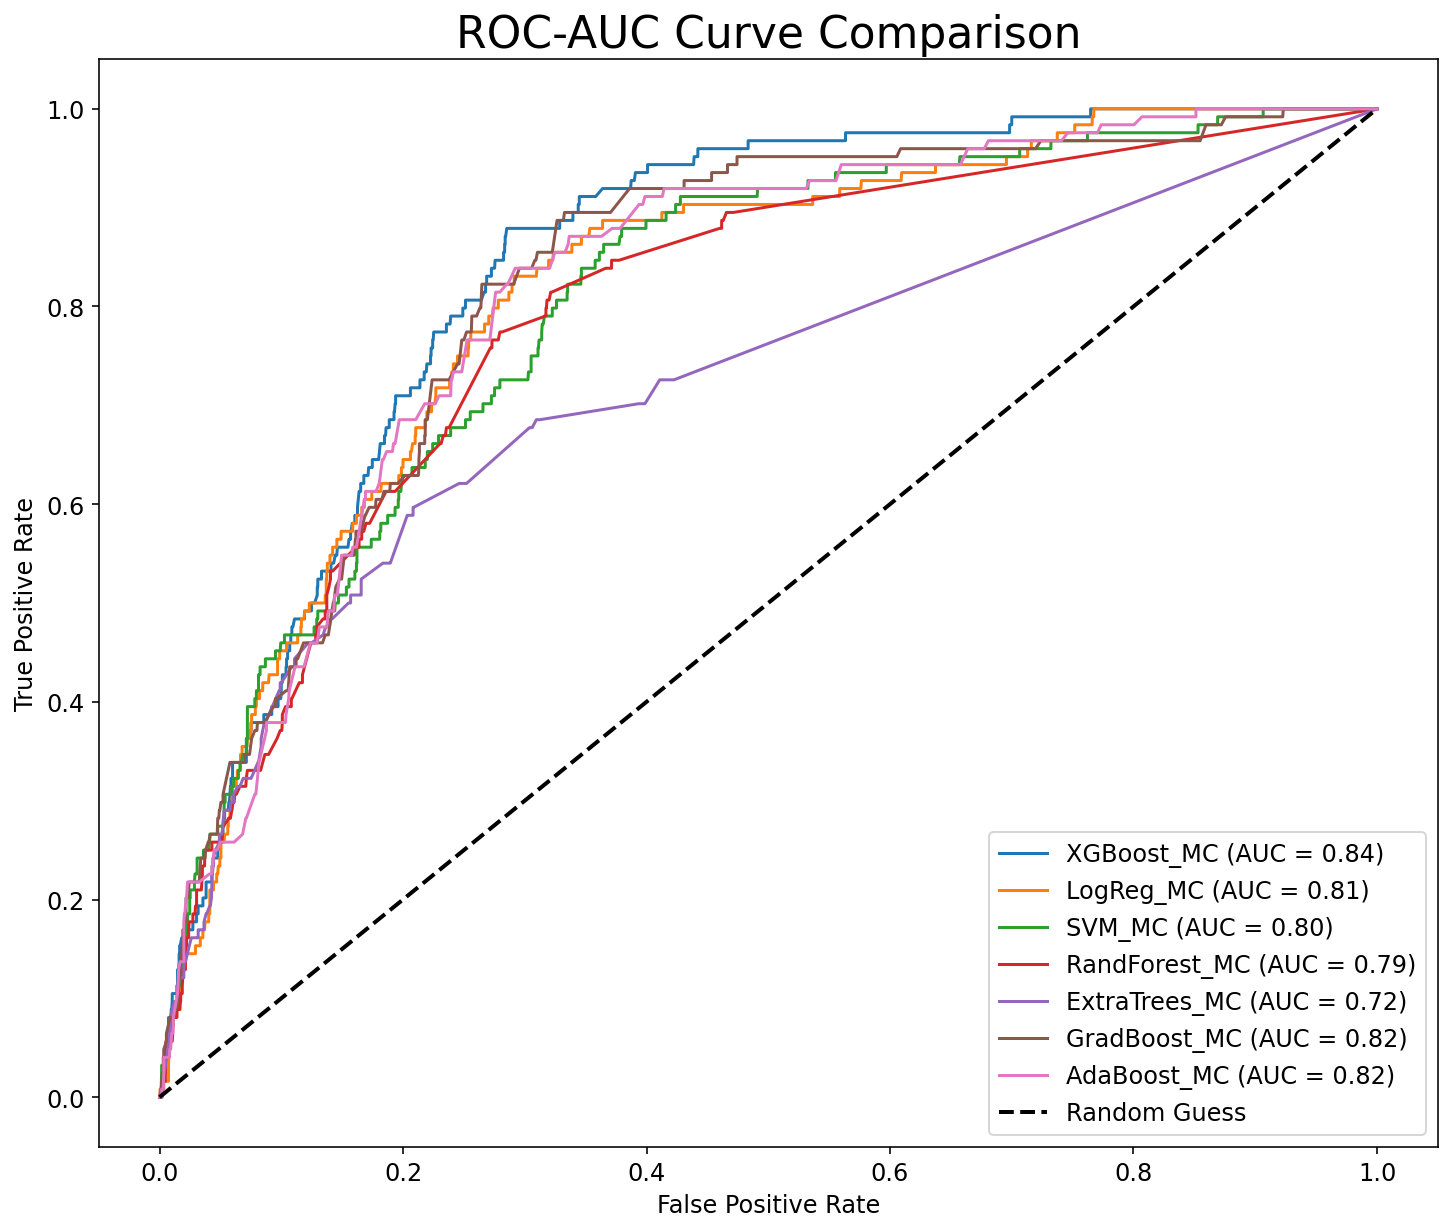

In [175]:
roc_curve_plotter(base_model_dict_multi)

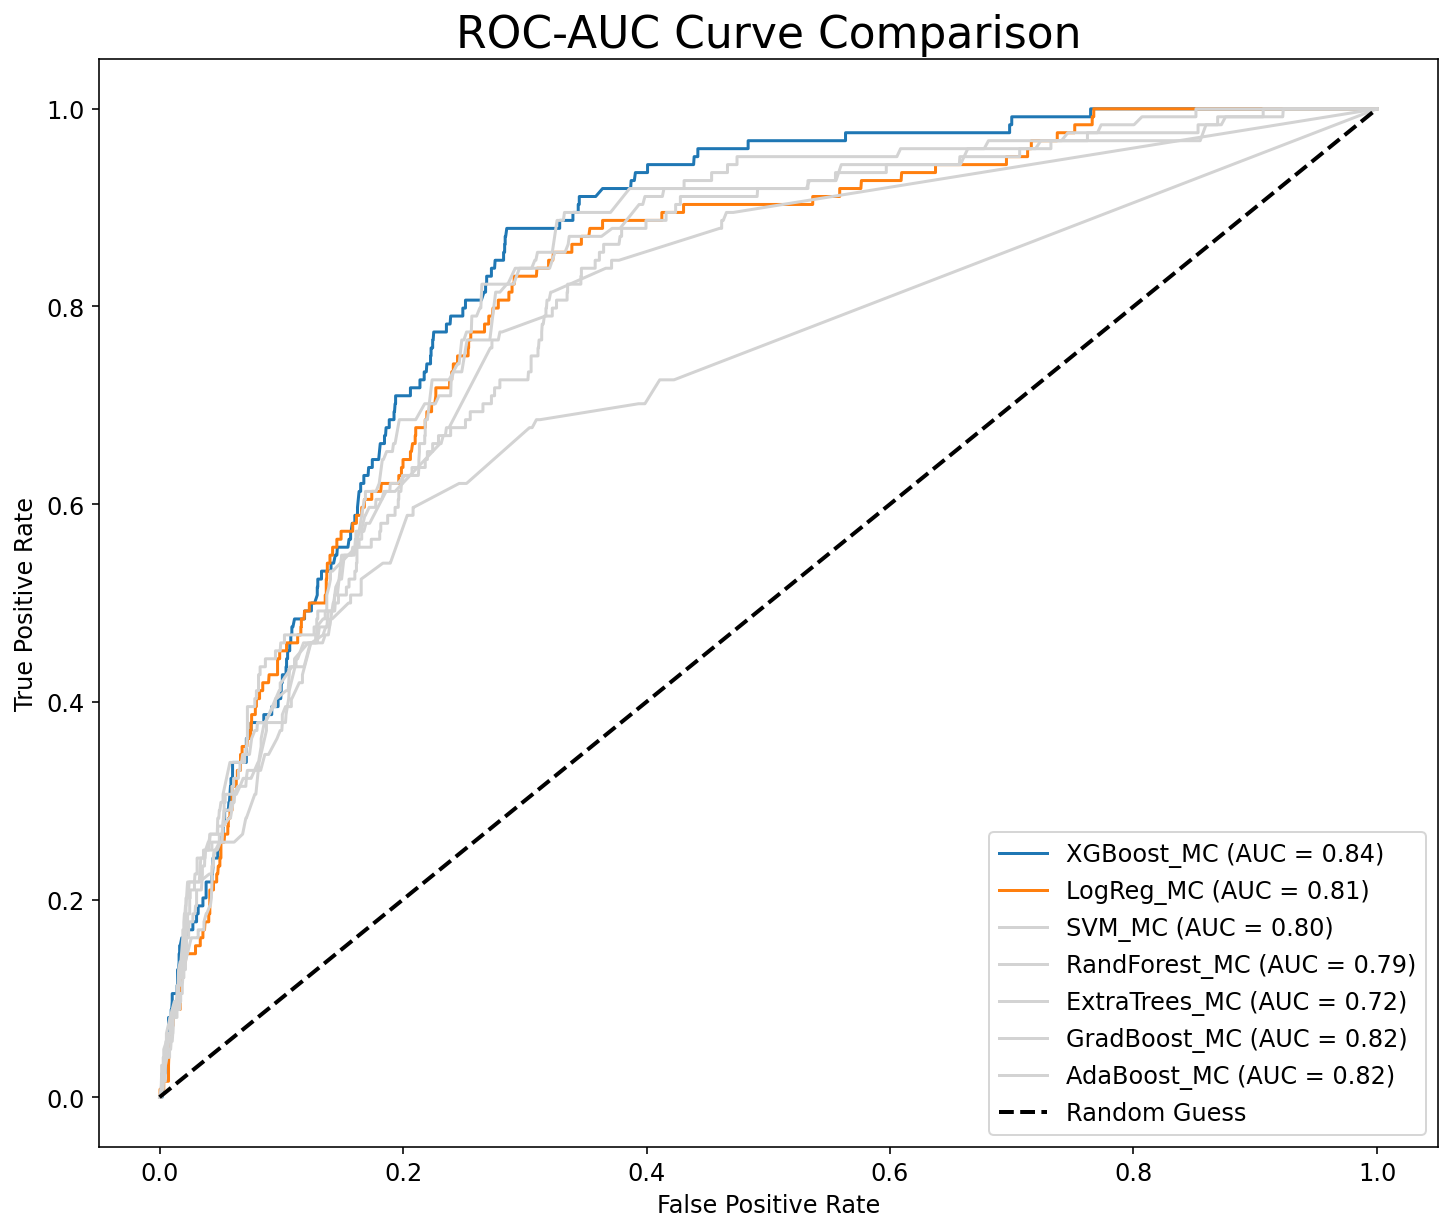

In [176]:
roc_curve_plotter(base_model_dict_multi, plot_top=True)

---

### Dataset with Features with minimal multicollinearity

First we will have to reset our `x` and `y` for the new dataset to feed into our modeling function.

In [6]:
# redefining our x, y for the new dataset
x = df_regression.drop(['wnvpresent'],axis=1)
y = df_regression['wnvpresent']

# check for imbalance, 
# expected to be same as previously seen
y.value_counts(normalize=True)

0    0.948107
1    0.051893
Name: wnvpresent, dtype: float64

In [7]:
# train_test_split on our previously defined x and y
x_train, x_test, y_train, y_test= train_test_split(x,y,random_state=42)

# scaling our features before using SMOTE
ss = StandardScaler()
x_train_sc = ss.fit_transform(x_train)
x_test_sc = ss.transform(x_test)

In [8]:
# initialize SMOTE
sm = SMOTE(random_state=42)

# resample on our train data
x_train_sc, y_train = sm.fit_resample(x_train_sc,y_train)

# sanity check to ensure our classes are balanced now
y_train.value_counts(normalize=True)

0    0.5
1    0.5
Name: wnvpresent, dtype: float64

---

Now we are ready to begin modeling for the dataset with minimal multi-collinearity. For simplicity's sake, we will refer to these models with the suffix `_reg`.

In [180]:
lr_base_reg = get_model_scores('lr_base_reg', 'lr')

METRICS-->


{'model_name': 'lr_base_reg',
 'model': 'lr',
 'train_score': 0.8401306240928882,
 'test_score': 0.7970297029702971,
 'recall': 0.6290322580645161,
 'specificity': 0.8060869565217391,
 'precision': 0.14885496183206107,
 'train_auc': 0.9056261783236891,
 'test_auc': 0.8137990883590465,
 'is_tuned': False}

True Negatives: 1854
False Positives: 446
False Negatives: 46
True Positives: 78


In [181]:
svm_base_reg = get_model_scores('svm_base_reg', 'svm')

METRICS-->


{'model_name': 'svm_base_reg',
 'model': 'svm',
 'train_score': 0.9523947750362844,
 'test_score': 0.884075907590759,
 'recall': 0.4032258064516129,
 'specificity': 0.91,
 'precision': 0.19455252918287938,
 'train_auc': 0.9914056993476168,
 'test_auc': 0.7934940392706873,
 'is_tuned': False}

True Negatives: 2093
False Positives: 207
False Negatives: 74
True Positives: 50


In [182]:
xg_base_reg = get_model_scores('xg_base_reg', 'xgb')

[21:52:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Jayy Jangam\.conda\envs\dsi\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


METRICS-->


{'model_name': 'xg_base_reg',
 'model': 'xgb',
 'train_score': 0.9766328011611031,
 'test_score': 0.943069306930693,
 'recall': 0.08870967741935484,
 'specificity': 0.9891304347826086,
 'precision': 0.3055555555555556,
 'train_auc': 0.9970649497283668,
 'test_auc': 0.8518636044880785,
 'is_tuned': False}

True Negatives: 2275
False Positives: 25
False Negatives: 113
True Positives: 11


In [183]:
rf_base_reg = get_model_scores('rf_base_reg', 'rf')

METRICS-->


{'model_name': 'rf_base_reg',
 'model': 'rf',
 'train_score': 0.9918722786647315,
 'test_score': 0.9426567656765676,
 'recall': 0.07258064516129033,
 'specificity': 0.9895652173913043,
 'precision': 0.2727272727272727,
 'train_auc': 0.9997507693992893,
 'test_auc': 0.7613990182328191,
 'is_tuned': False}

True Negatives: 2276
False Positives: 24
False Negatives: 115
True Positives: 9


In [184]:
et_base_reg = get_model_scores('et_base_reg', 'et')

METRICS-->


{'model_name': 'et_base_reg',
 'model': 'et',
 'train_score': 0.9918722786647315,
 'test_score': 0.9434818481848185,
 'recall': 0.07258064516129033,
 'specificity': 0.9904347826086957,
 'precision': 0.2903225806451613,
 'train_auc': 0.9998393056131918,
 'test_auc': 0.6875981767180925,
 'is_tuned': False}

True Negatives: 2278
False Positives: 22
False Negatives: 115
True Positives: 9


In [185]:
gb_base_reg = get_model_scores('gb_base_reg', 'gb')

METRICS-->


{'model_name': 'gb_base_reg',
 'model': 'gb',
 'train_score': 0.9591436865021771,
 'test_score': 0.9393564356435643,
 'recall': 0.0967741935483871,
 'specificity': 0.9847826086956522,
 'precision': 0.2553191489361702,
 'train_auc': 0.9903569886312171,
 'test_auc': 0.8136851332398317,
 'is_tuned': False}

True Negatives: 2265
False Positives: 35
False Negatives: 112
True Positives: 12


In [186]:
ada_base_reg = get_model_scores('ada_base_reg', 'ada')

METRICS-->


{'model_name': 'ada_base_reg',
 'model': 'ada',
 'train_score': 0.9404934687953556,
 'test_score': 0.9137788778877888,
 'recall': 0.1935483870967742,
 'specificity': 0.9526086956521739,
 'precision': 0.18045112781954886,
 'train_auc': 0.9838635219423619,
 'test_auc': 0.8003699158485273,
 'is_tuned': False}

True Negatives: 2191
False Positives: 109
False Negatives: 100
True Positives: 24


Now let's take a look at only the models that used the 'regression dataset' and plot out the ROC curve as well.

In [188]:
baseline_model_scores = pd.DataFrame(model_eval)

In [189]:
baseline_model_scores.loc[baseline_model_scores['model_name']\
                      .str.contains('reg'), 
                          ['model_name', 'recall', 'test_auc']]\
                      .sort_values('recall', ascending=False)

,model_name,recall,test_auc
7,lr_base_reg,0.629032,0.813799
8,svm_base_reg,0.403226,0.793494
13,ada_base_reg,0.193548,0.800370
12,gb_base_reg,0.096774,0.813685
9,xg_base_reg,0.088710,0.851864
10,rf_base_reg,0.072581,0.761399
11,et_base_reg,0.072581,0.687598


Now let's evaluate all our models and see which model, and which dataset has performed the best. Based on this, we will decide which models to further tune.<br>
The main metrics we are looking for are `recall` and `test_auc` as mentioned earlier.

In [190]:
# creating dictionary for ROC curve plotter
base_model_dict_reg = {
    xg_base_reg: 'XGBoost_reg',
    lr_base_reg: 'LogReg_reg',
    svm_base_reg: 'SVM_reg',
    rf_base_reg: 'RandForest_reg', 
    et_base_reg: 'ExtraTrees_reg',
    gb_base_reg: 'GradBoost_reg', 
    ada_base_reg: 'AdaBoost_reg'}

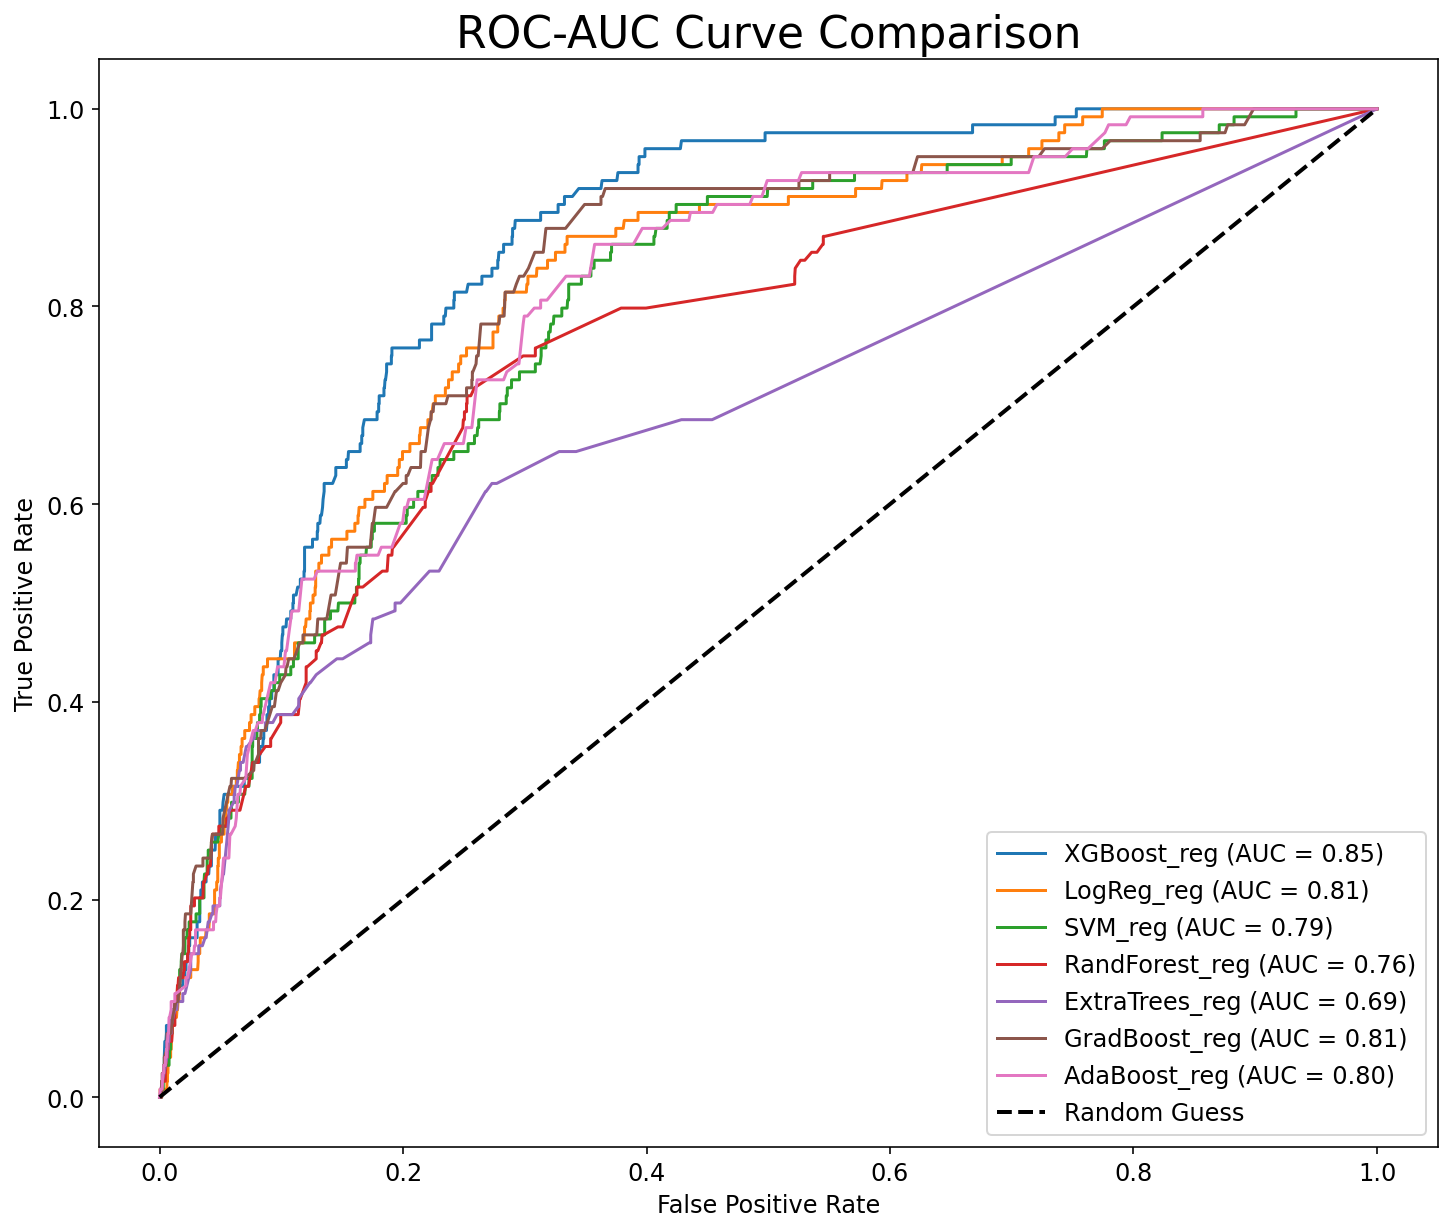

In [191]:
roc_curve_plotter(base_model_dict_reg)

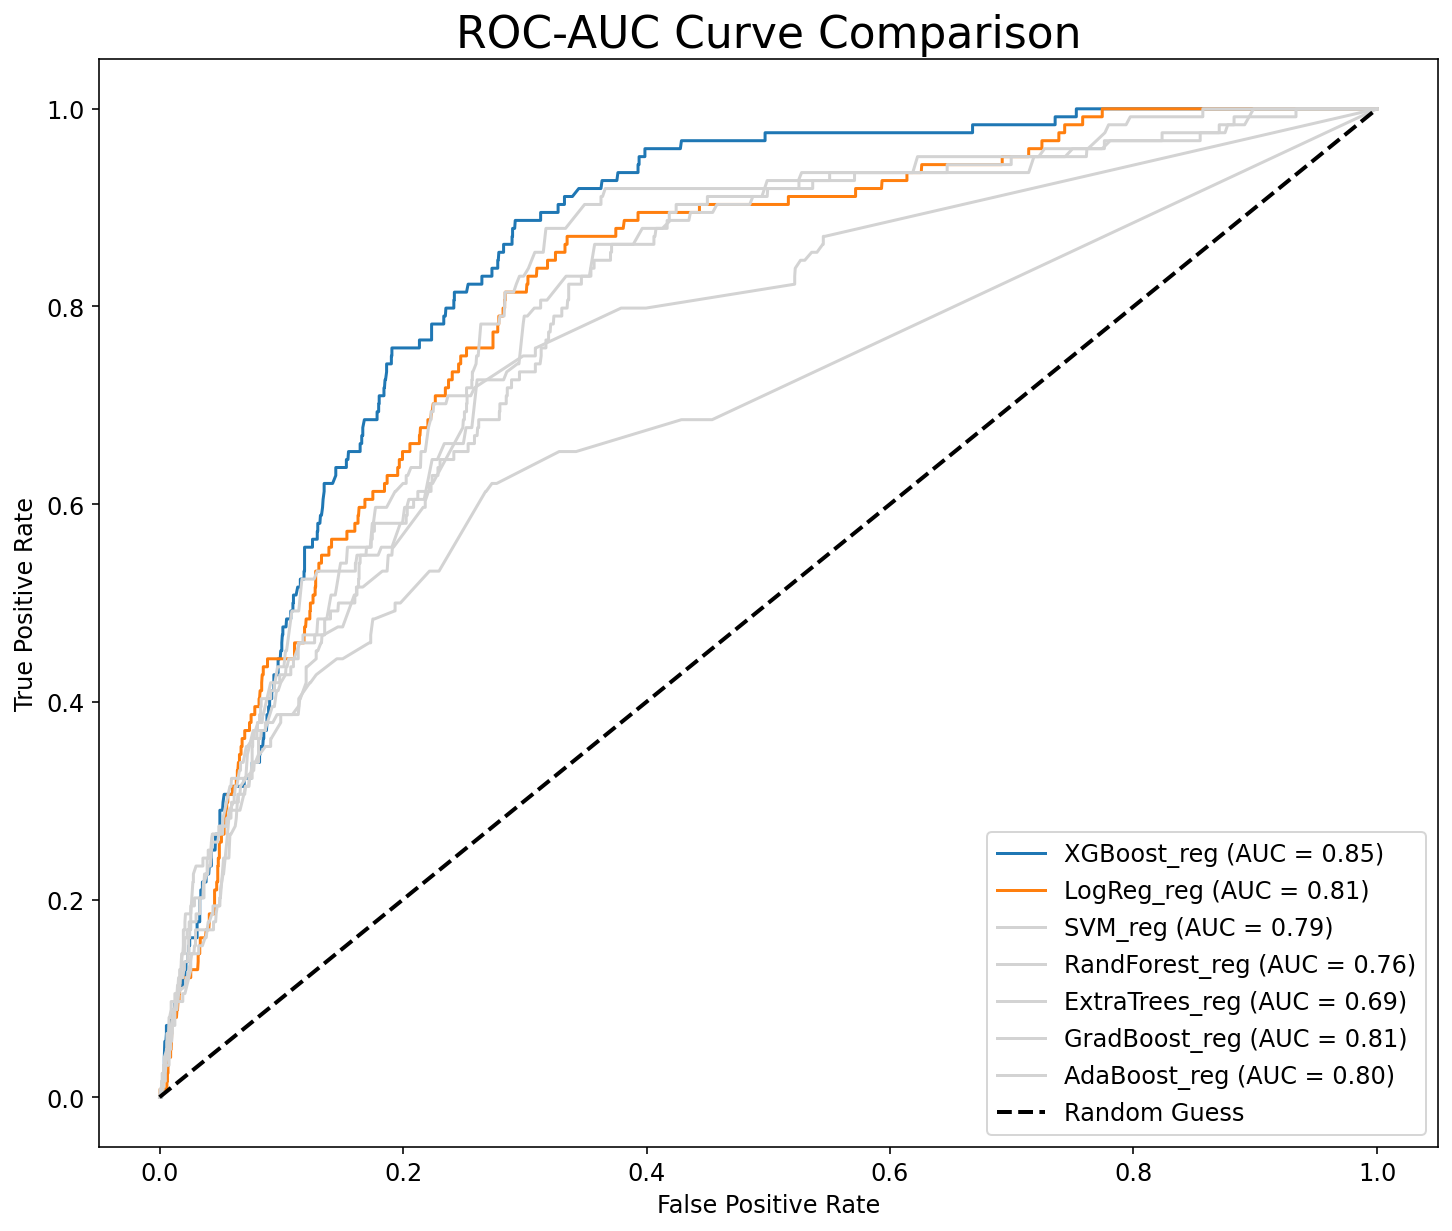

In [192]:
roc_curve_plotter(base_model_dict_reg, plot_top=True)

Now let's re-evaluate all our models created this far, and select the best models for hyperparameter tuning.

In [193]:
base_model_scores = pd.DataFrame(model_eval)

base_model_scores.sort_values(by=['recall', 
                                  'test_auc'], 
                              ascending=False)[['model_name', 
                                                'model','recall', 
                                                'test_auc']]

,model_name,model,recall,test_auc
7,lr_base_reg,lr,0.629032,0.813799
0,lr_base_multi,lr,0.620968,0.814525
1,svm_base_multi,svm,0.411290,0.803701
8,svm_base_reg,svm,0.403226,0.793494
6,ada_base_multi,ada,0.225806,0.816133
13,ada_base_reg,ada,0.193548,0.800370
5,gb_base_multi,gb,0.169355,0.822053
12,gb_base_reg,gb,0.096774,0.813685
9,xg_base_reg,xgb,0.088710,0.851864
2,xg_base_multi,xgb,0.088710,0.842081


In each case, the `_multi` models seems to have outperformed the `_reg` models, **EXCEPT** for the `LogisticRegression` model. i.e. the dataset containing features with multi-collinearity performs better than the dataset without. 

As such, moving forward we will conduct tuning of the `LogisticRegression` model both datasets since the results are so close, and the rest of our models with only the dataset with features having multi-collinearity.

We will select the model types that have `test_auc` scores greater than *80%.*

---

## Model Tuning

The models we have identified to be tuned from the baseline models are our top **five** model types, which had `test_auc` scores above *80%*. They are:</p>
1. `LogisticRegression`
2. `SVM`
3. `XGBoost`
4. `AdaBoost`
5. `GradientBoost`

### Tuning with minimal multicollinearity

Since our currently defined `x` and `y` are already from `df_regression` (dataset with minimal multi-collinearity), we will proceed with this hyper parameter tuning first. <br>

We will evaluate all model performance all together after attempting tuning for all of them.

In [68]:
# defining LogisticRegression params for 
# hyperparameter tuning

lr_params = {
    # Trying different types of regularization
    'lr__penalty':['l2','l1'],

    'lr__C':[0.1, 1, 2, 3],
}



In [11]:
lr_tuned_reg = get_model_scores('lr_tuned_reg', 'lr', 
                            mod_params=lr_params, 
                            grid_search=True)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
BEST PARAMS-->


{'lr__C': 1, 'lr__penalty': 'l2'}

METRICS-->


{'model_name': 'lr_tuned_reg',
 'model': 'lr',
 'train_score': 0.8401306240928882,
 'test_score': 0.7970297029702971,
 'recall': 0.6290322580645161,
 'specificity': 0.8060869565217391,
 'precision': 0.14885496183206107,
 'train_auc': 0.9056261783236891,
 'test_auc': 0.8137990883590465,
 'is_tuned': True}

True Negatives: 1854
False Positives: 446
False Negatives: 46
True Positives: 78


Now we will tune all our models, with the dataset *having* multi-collinearity.

### Tuning with multicollinearity

### redefining `x` and `y` for dataset with features having multi-collinearity

In [10]:
x = df_multi.drop(['wnvpresent'],axis=1)
y = df_multi['wnvpresent']

y.value_counts(normalize=True)

0    0.948107
1    0.051893
Name: wnvpresent, dtype: float64

In [11]:
x_train, x_test, y_train, y_test= train_test_split(x,y,random_state=42)

ss = StandardScaler()
x_train_sc = ss.fit_transform(x_train)
x_test_sc = ss.transform(x_test)

In [12]:
sm = SMOTE(random_state=42)

x_train_sc, y_train = sm.fit_resample(x_train_sc,y_train)

y_train.value_counts(normalize=True)

0    0.5
1    0.5
Name: wnvpresent, dtype: float64

Now we can begin tuning our models.

In [ ]:
lr_params = {
    # Trying different types of regularization
    'lr__penalty':['l2','l1'],

    'lr__C':[1, 10, 20],
}

svc_params = {
    'svm__C':[1, 10],
    'svm__gamma':['scale', 'auto'], 
    'svm__kernel':['rbf', 'sigmoid'],
}

xg_params = {
    'xgb__booster': ['gbtree', 'gblinear'],
    'xgb__scale_pos_weight': [0.5,1],
    'xgb__gamma': [0,1],
    'xgb__reg_alpha': [0, 1],
    'xgb__reg_lambda': [1, 5]
}

ada_params = {'ada__n_estimators': [500, 1000, 1500],
              'ada__learning_rate': [0.9, 0.95, 1.0]
             }

gb_params = {'gb__n_estimators': [500, 1000, 1500],
             'gb__learning_rate': [0.2, 0.3, 0.4, 0.5],
}

We will use the previously defined custom function to help us fit the tuned models.

**Please note, all the tuned models were lost when the notebook crashed, as such in the interst of time, we ran the previoulsy tuned parameters so that we may plot the ROC_AUC charts and look closely at the results.**

In [62]:
lr_tuned = get_model_scores('lr_tuned', 'lr', 
                            mod_params=lr_params, 
                            grid_search=True)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
BEST PARAMS-->


{'lr__C': 1, 'lr__penalty': 'l2'}

METRICS-->


{'model_name': 'lr_tuned',
 'model': 'lr',
 'train_score': 0.8417271407837446,
 'test_score': 0.7941419141914191,
 'recall': 0.6209677419354839,
 'specificity': 0.8034782608695652,
 'precision': 0.14555765595463138,
 'train_auc': 0.9072783066264184,
 'test_auc': 0.8145248948106592,
 'is_tuned': True}

True Negatives: 1848
False Positives: 452
False Negatives: 47
True Positives: 77


In [63]:
svm_tuned = get_model_scores('svm_tuned', 'svm', 
                            mod_params=svc_params, 
                            grid_search=True)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
BEST PARAMS-->


{'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}

METRICS-->


{'model_name': 'svm_tuned',
 'model': 'svm',
 'train_score': 0.9794629898403483,
 'test_score': 0.9108910891089109,
 'recall': 0.2903225806451613,
 'specificity': 0.9443478260869566,
 'precision': 0.21951219512195122,
 'train_auc': 0.9978385304210262,
 'test_auc': 0.7724982468443198,
 'is_tuned': True}

True Negatives: 2172
False Positives: 128
False Negatives: 88
True Positives: 36


In [64]:
ada_tuned = get_model_scores('ada_tuned', 'ada', 
                             mod_params=ada_params, 
                             grid_search=True)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
BEST PARAMS-->


{'ada__learning_rate': 1.0, 'ada__n_estimators': 1500}

METRICS-->


{'model_name': 'ada_tuned',
 'model': 'ada',
 'train_score': 0.9674165457184325,
 'test_score': 0.9438943894389439,
 'recall': 0.1532258064516129,
 'specificity': 0.9865217391304347,
 'precision': 0.38,
 'train_auc': 0.9941719557382125,
 'test_auc': 0.8482503506311361,
 'is_tuned': True}

True Negatives: 2269
False Positives: 31
False Negatives: 105
True Positives: 19


In [65]:
gb_tuned = get_model_scores('gb_tuned', 'gb', 
                            mod_params=gb_params, 
                            grid_search=True)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
BEST PARAMS-->


{'gb__learning_rate': 0.4, 'gb__n_estimators': 1500}

METRICS-->


{'model_name': 'gb_tuned',
 'model': 'gb',
 'train_score': 0.9918722786647315,
 'test_score': 0.9335808580858086,
 'recall': 0.16129032258064516,
 'specificity': 0.9752173913043478,
 'precision': 0.2597402597402597,
 'train_auc': 0.9998331125018696,
 'test_auc': 0.8168460729312763,
 'is_tuned': True}

True Negatives: 2243
False Positives: 57
False Negatives: 104
True Positives: 20


In [66]:
xg_tuned = get_model_scores('xg_tuned', 'xgb', 
                            mod_params=xg_params, 
                            grid_search=True)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\Jayy Jangam\.conda\envs\dsi\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:10:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
BEST PARAMS-->


{'xgb__booster': 'gbtree',
 'xgb__gamma': 1,
 'xgb__reg_alpha': 0,
 'xgb__reg_lambda': 1,
 'xgb__scale_pos_weight': 0.5}

METRICS-->


{'model_name': 'xg_tuned',
 'model': 'xgb',
 'train_score': 0.9709724238026125,
 'test_score': 0.9463696369636964,
 'recall': 0.04838709677419355,
 'specificity': 0.9947826086956522,
 'precision': 0.3333333333333333,
 'train_auc': 0.9952028981233186,
 'test_auc': 0.8376770687237026,
 'is_tuned': True}

True Negatives: 2288
False Positives: 12
False Negatives: 118
True Positives: 6


In [73]:
# check model eval to have a table output for our models.
tuned_model_scores = pd.DataFrame(model_eval)

# sort values for recall score
tuned_model_scores[['model_name', 'recall', 'test_auc']]\
.sort_values(by='recall', ascending=False)

,model_name,recall,test_auc
0,lr_tuned,0.620968,0.814525
1,svm_tuned,0.290323,0.772498
3,gb_tuned,0.161290,0.816846
2,ada_tuned,0.153226,0.848250
4,xg_tuned,0.048387,0.837677


From the table above, we should definitely see if we can futher tune `LogisticRegression` and `AdaBoost` as they have the best `test_auc` scores, although `LogisticRegression` has a far better recall score. Although `XGBoost` has a really good `test_auc` score as well, it's recall score is really bad, as such we will no longer tune that model.

In [77]:
# creating dictionary for ROC curve plotter
tuned_model_dict_multi = {
    ada_tuned: 'ada_tuned',
    lr_tuned: 'lr_tuned',
    xg_tuned: 'xg_tuned',
    svm_tuned: 'svm_tuned', 
    gb_tuned: 'gb_tuned'}

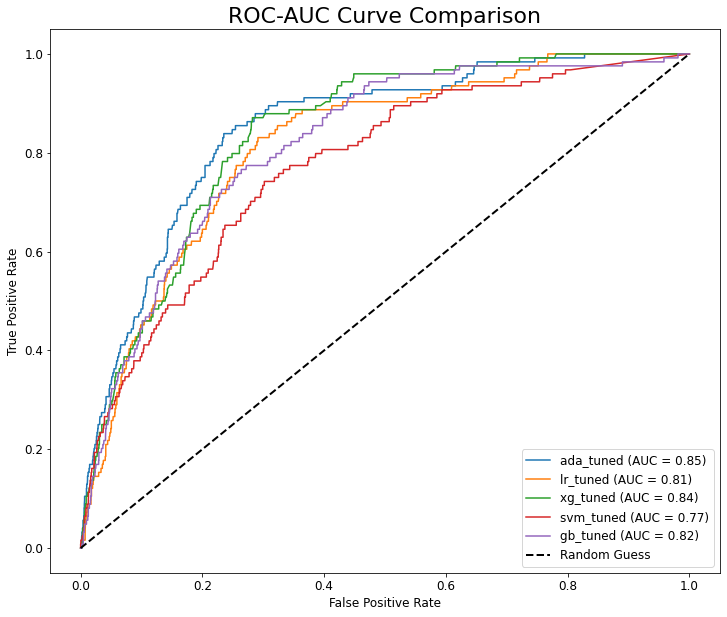

In [78]:
roc_curve_plotter(tuned_model_dict_multi)

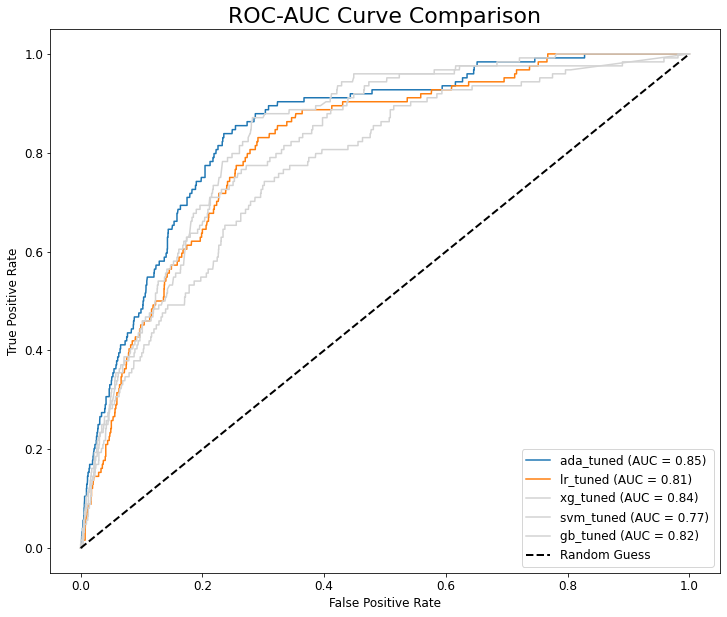

In [79]:
roc_curve_plotter(tuned_model_dict_multi, plot_top=True)

Based on this we can select our best model(s) on a combination of `recall` score and `test_auc` score.\
From the above, we will select `LogisticRegression`, `AdaBoost` and `GradientBoost` for further tuning. 

Our best model for recall score is the `LogisticRegression`. There seems to be minimal difference between the two different datasets. As such to make matters simpler, we will conduct any further tuning with the dataset that has features with multi-collinearity within them.

---

---

## Further tuning our best model

From this table, we can see that although the `test_auc` score is lower for our best logistic regressor, the logisitic regressor peforms best on the recall score. <br>

After looking through our features and our model performance, we have decided to test a few other features in hopes of improving our models. The steps we will take are outlined below:

1. Initially during feature engineering, we had identified `nummosquitos` as having the highest correlation with our target, `wnvpresent`. To improve our `LogisticRegression` model, we will try to use `LinearRegression` to first predict the `nummosquitos`, for the test dataset, and then use that for the kaggle submission.
2. We will also pass in the dummified `month` column into our dataset.

***We have created this model in notebook 5, title "5. Nummosquitos Prediction Model".***

Let's add in our additional features to our dataset with multicollinearity, which is what we will use for our final model.

In [125]:
# re-reading in our original merged dataset to add the month column to our dataset
df_merged = pd.read_csv('../data/weather_train_merged.csv')

In [126]:
df_multi = pd.concat([df_multi, df_merged[['month', 'nummosquitos']]], axis=1)

In [127]:
# dummifying the month column in our regression
df_multi = pd.get_dummies(
    df_multi,
    columns=['month'],
    drop_first=True
)

In [128]:
df_multi['nummosquitos*week'] = df_multi['nummosquitos']*df_merged['week']

Now that we have the final dataset that we will use for modeling, let's save this as a csv file.

In [129]:
# saving final dataset to csv
df_multi.to_csv('../data/final_train.csv', index=False)

Now we will rerun our final model to see if there have been any improvement in the score.

In [19]:
x = df_multi.drop(['wnvpresent'],axis=1)
y = df_multi['wnvpresent']

y.value_counts(normalize=True)

0    0.948107
1    0.051893
Name: wnvpresent, dtype: float64

In [20]:
x_train, x_test, y_train, y_test= train_test_split(x,y,random_state=42)

ss = StandardScaler()
x_train_sc = ss.fit_transform(x_train)
x_test_sc = ss.transform(x_test)

In [21]:
sm = SMOTE(random_state=42)

x_train_sc, y_train = sm.fit_resample(x_train_sc,y_train)

y_train.value_counts(normalize=True)

0    0.5
1    0.5
Name: wnvpresent, dtype: float64

### Final Model Tune

In [23]:
# Updating params based on previously found best params

lr_params_V2 = {
    'lr__penalty':['l2'],
    'lr__C':[1],
}

In [24]:
lr_final_tuned = get_model_scores('lr_final_tuned', 
                                  'lr', 
                                  mod_params=lr_params_V2, 
                                  grid_search=True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
BEST PARAMS-->


{'lr__C': 1, 'lr__penalty': 'l2'}

METRICS-->


{'model_name': 'lr_final_tuned',
 'model': 'lr',
 'train_score': 0.8677068214804063,
 'test_score': 0.8403465346534653,
 'recall': 0.6854838709677419,
 'specificity': 0.8486956521739131,
 'precision': 0.19630484988452657,
 'train_auc': 0.9339254214580776,
 'test_auc': 0.8509782608695653,
 'is_tuned': True}

True Negatives: 1952
False Positives: 348
False Negatives: 39
True Positives: 85


This is our best `LogisticRegression` model so far. Let's see if we can push our other models further.

Previously when we tuned our model, we found that the `AdaBoost` and `GradientBoost` models gave us the better `test_auc` scores. Now we will attempt to put the best `LogisticRegression` model as the base estimator in our `AdaBoost` and `GradientBoost` models, in hopes that this further improves the performance.

In [25]:
# redefine models with changed base-estimator for ada and gb models
# models is defined with the same name for our modeling function
models = {'ada': AdaBoostClassifier(random_state=42, 
                                    base_estimator=LogisticRegression(max_iter=5000, 
                                                                      C=1, 
                                                                      penalty='l2')),
          'gb': GradientBoostingClassifier(random_state=42, 
                                           init=LogisticRegression(max_iter=5000,
                                                                   C=1, 
                                                                   penalty='l2')),
}

In [30]:
ada_logreg_tuned = get_model_scores('ada_logreg_tuned', 
                                    'ada',
                                    mod_params=ada_params, 
                                    grid_search=True)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
BEST PARAMS-->


{'ada__learning_rate': 1.0, 'ada__n_estimators': 1500}

METRICS-->


{'model_name': 'ada_logreg_tuned_V2',
 'model': 'ada',
 'train_score': 0.8592162554426706,
 'test_score': 0.8403465346534653,
 'recall': 0.6854838709677419,
 'specificity': 0.8486956521739131,
 'precision': 0.19630484988452657,
 'train_auc': 0.9319199487699091,
 'test_auc': 0.8479137447405329,
 'is_tuned': True}

True Negatives: 1952
False Positives: 348
False Negatives: 39
True Positives: 85


In [42]:
gb_logreg_tuned = get_model_scores('gb_logreg_tuned', 
                                   'gb', 
                                   mod_params=gb_params, 
                                   grid_search=True)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
BEST PARAMS-->


{'gb__learning_rate': 0.2, 'gb__n_estimators': 500}

METRICS-->


{'model_name': 'gb_logreg_tuned',
 'model': 'gb',
 'train_score': 0.9904934687953556,
 'test_score': 0.9348184818481848,
 'recall': 0.20161290322580644,
 'specificity': 0.9743478260869565,
 'precision': 0.2976190476190476,
 'train_auc': 0.9996762308808752,
 'test_auc': 0.8604277699859748,
 'is_tuned': True}

True Negatives: 2241
False Positives: 59
False Negatives: 99
True Positives: 25


In [51]:
scores = pd.DataFrame(model_eval)
scores[['model_name', 'recall', 'test_auc']]

,model_name,recall,test_auc
0,lr_final_tuned,0.685484,0.850978
1,ada_logreg_tuned,0.685484,0.847914
2,gb_logreg_tuned,0.201613,0.860428


From the above table, we can see that the `LogisticRegression` model in row 0 gives us the best result when we look at both `recall` score and `test_auc` score. As such, we will use this model as our final model for the kaggle test data prediction, as well as insights and error analysis.

In [55]:
final_models = {
    lr_final_tuned: 'LogReg_tuned_final',
    ada_logreg_tuned: 'AdaBoost_tuned_final',
    gb_logreg_tuned: 'GradBoost_turned_final',
}

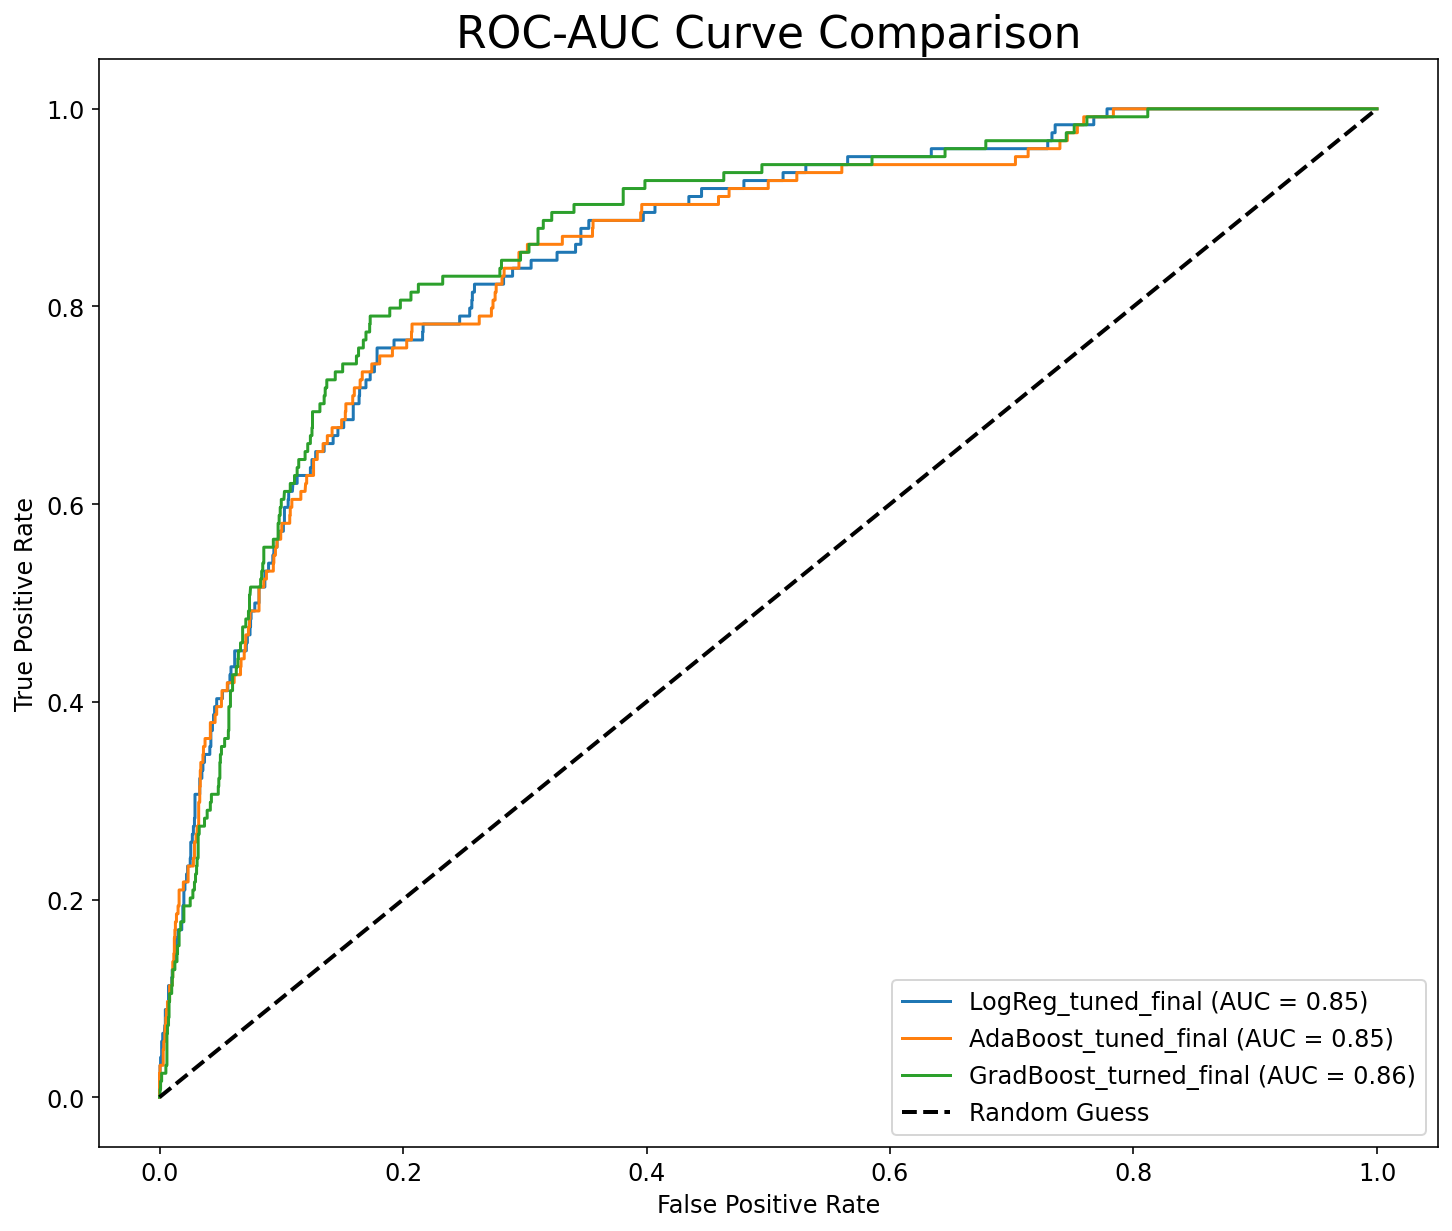

In [49]:
roc_curve_plotter(final_models)

In [49]:
def plot_pr_curve(model, model_dict, labelling):
    # Predict probabilities
    probs = model.predict_proba(x_test_sc)
    # Keep probabilities for the positive outcome only
    probs = probs[:, 1]
    # Predict class values
    yhat = model.predict(x_test_sc)
    # Calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    # Calculate F1 score
    f1 = f1_score(y_test, yhat)
    # Calculate precision-recall AUC
    auc_score = auc(recall, precision)
    # Calculate average precision score
    ap = average_precision_score(y_test, probs)
    print(f'{model_dict[model]}: f1=%.3f pr-auc=%.3f avg. prec=%.3f' % (f1, auc_score, ap))
    # Plot the ROC curve for the model
    plt.plot(recall, precision, marker='.', label=labelling)
    plt.xlabel('Recall')
    plt.ylabel('Precision');

LogReg_tuned_final: f1=0.237 pr-auc=0.172 avg. prec=0.177
AdaBoost_tuned_final: f1=0.248 pr-auc=0.173 avg. prec=0.177
GradBoost_turned_final: f1=0.203 pr-auc=0.217 avg. prec=0.221


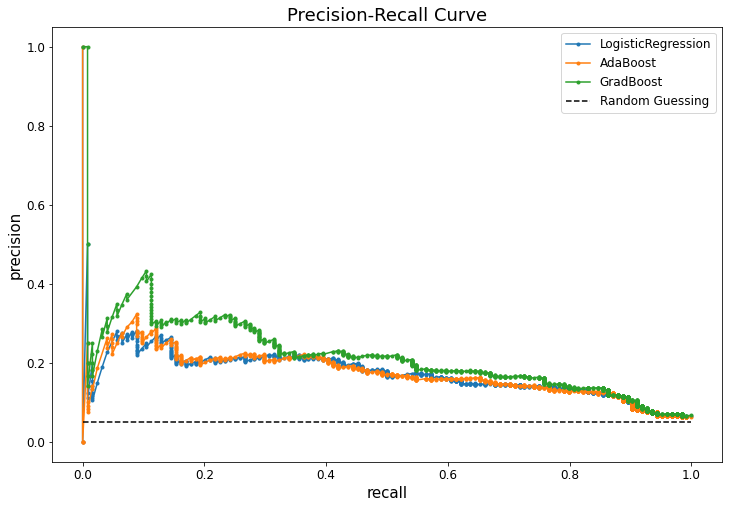

In [54]:
# define figure
plt.figure(figsize=(12,8))

#call custom function to plot the pr_curve
plot_pr_curve(lr_final_tuned, final_models, 'LogisticRegression');
plot_pr_curve(ada_logreg_tuned, final_models, 'AdaBoost');
plot_pr_curve(gb_logreg_tuned, final_models, 'GradBoost');

# plot random guessing line
plt.plot([0, 1], [0.05, 0.05], linestyle='--', color = 'black', label='Random Guessing')

# chart titles axis headings etc
plt.title('Precision-Recall Curve', fontsize=18)
plt.xlabel('recall', fontsize=15)
plt.ylabel('precision', fontsize=15)
plt.legend(fontsize=12);

As we can see, all of our final models are very close on the `ROC_AUC` curve, however the difference exists between the `recall` score.


| model_name | recall | test_auc |
| --- | --- | --- |
| 0 | lr_final_tuned | 0.685484 | 0.850978 |
| 1 | ada_logreg_tuned | 0.685484 | 0.847914 |
| 2 | gb_logreg_tuned | 0.201613 | 0.860428 |

From the above table, we can see that `LogisticRegression` and `AdaBoost` with `LogisticRegression` as the base_estimator have the same recall score, which is much higher than the one for `GradientBoost` with `LogisticRegression` as the base_estimator. 

When we look at both the two scores, (`recall` and `test_auc`), `LogisticRegression` is the clear winner and so it becomes our final model.

From the *Precision vs Recall* chart, we can see that `LogisticRegression` may not have the greatest tradeoff between the two, however we believe that the recall score is much more important as misclassifying a positive class can result in human death which is a much more serious outcome.

## Kaggle Submission Prediction

With this, we can now go ahead and create our final model that will make predictions for the kaggle test dataset. We will use our entire dataset to train this model, and make the submission on kaggle.
<br>

We will take the following steps for our model:
1. Prepare our test dataset as we have made some changes to our training dataset earlier.
    * This will involve reading in the `nummosquitos` predictions that we made in the prediction model notebook.
2. Fit a `LogisticRegression` with all of our data with the best parameters.
3. Make predictions with the model using our test data before submitting to kaggle.

In [130]:
# re-reading in our test merged dataset to add the month column to our dataset
df_merged_test = pd.read_csv('../data/weather_test_merged.csv')

# reading in the nummosquitos predictions from prediction model notebook
nummosquitos_preds = pd.read_csv('../data/nummosquitos_preds.csv')

In [131]:
test_df_multi = pd.concat([test_df_multi, df_merged_test['month'], nummosquitos_preds['nummosquitos']], axis=1)

In [132]:
# dummifying the month column in our regression
test_df_multi = pd.get_dummies(
    test_df_multi,
    columns=['month'],
    drop_first=True
)

In [133]:
# manually creating a interaction column
test_df_multi['nummosquitos*week'] = test_df_multi['nummosquitos']*df_merged_test['week']

Our test dataset seems to be missing a 'month_6' column, so we'll have to add that in.

In [134]:
test_df_multi['month_6'] = 0

Lastly, the order of our columns will affect our prediction, so let's ensure our test dataset's columns are in the same order as the train dataset.

In [135]:
# re-ordering the columns
train_cols = x.columns.tolist()
test_df_multi = test_df_multi[train_cols]

In [136]:
# sanity check to ensure columns are in the same order
train_cols == test_df_multi.columns.tolist()

True

Now that we have the final dataset that we will use for modeling, let's save this as a csv file.

In [139]:
# saving final dataset to csv
test_df_multi.to_csv('../data/final_test.csv', index=False)

We will now proceed to train our final model with all of our data, and then create the predictions file for submission to Kaggle.

In [80]:
# defining our final X and y
X_final = df_multi.drop(['wnvpresent'],axis=1)
y_final = df_multi['wnvpresent']

y_final.value_counts(normalize=True)

0    0.948107
1    0.051893
Name: wnvpresent, dtype: float64

In [81]:
ss = StandardScaler()
X_final_sc = ss.fit_transform(X_final)

In [82]:
sm = SMOTE(random_state=42)

X_final_sc, y_final = sm.fit_resample(X_final_sc,y_final)

y_final.value_counts(normalize=True)

0    0.5
1    0.5
Name: wnvpresent, dtype: float64

In [143]:
# defining our final X_test
X_test_final = test_df_multi
X_test_final_sc = ss.transform(X_test_final)

In [145]:
# creating our final model
kaggle_model = LogisticRegression(max_iter=10_000, penalty='l2', C=1)
kaggle_model.fit(X_final_sc, y_final)

LogisticRegression(C=1, max_iter=10000)

In [164]:
# getting predictions
preds = kaggle_model.predict(X_test_final_sc)

In [167]:
# creating empty predictions DataFrame
df_preds = pd.DataFrame(columns=['Id', 'WnvPresent'])

In [172]:
# arranging predictions in the format required by kaggle
df_preds['WnvPresent'] = preds
df_preds['Id'] = df_preds.index
df_preds['Id'] = df_preds['Id'].map(lambda x: x+1)
df_preds['WnvPresent'].value_counts(normalize=True)

0    0.93813
1    0.06187
Name: WnvPresent, dtype: float64

In [174]:
# saving the final kaggle prediction
df_preds.to_csv('../data/wnv_kagglesubmission.csv', index=False)

In the next notebook, we will be taking a look at the error analysis of our model the insights and conclusion we can draw from this project.

---